In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mlrose_hiive as mr
import time
import itertools
import pandas as pd

In [2]:
np.random.seed(1)

### Randomized optimization

In [3]:
weights = np.random.randint(1, 100, size = 10)
values = np.random.randint(1, 100, size = 10)
# create problems:
problems = {
    'Knapsack': mr.DiscreteOpt(length=10, maximize=True,
                                fitness_fn=mr.Knapsack(weights, values)),
    'ContinuousPeaks': mr.DiscreteOpt(length=100, maximize=True,
                                     fitness_fn=mr.ContinuousPeaks()),
    'FlipFlop': mr.DiscreteOpt(length=100, maximize=True,
                                      fitness_fn=mr.FlipFlop())
}

In [4]:
# returns a list of dicts for each hyperparameter combination
# ie, hyper_names=['a', 'b'] and hyper_list=[[1], [4, 5]] returns [{'a':1, 'b':4}, {'a':1, 'b':5}
def helperIterateHyperParams(hyper_names, hyper_list):
    unnamed_combos = list(itertools.product(*hyper_list))
    list_of_dicts = []
    for combo in unnamed_combos:
        subDict = {}
        for i in range(len(hyper_names)):
            hyper_name = hyper_names[i]
            subDict[hyper_name] = combo[i]
        list_of_dicts.append(subDict)
    
    return list_of_dicts
            
# returns optimal parameters for algo from input hyper_params for given problem 
# for example
# algo = mr.random_hill_climb 
# problem = mr.DiscreteOpt(length=100, maximize=True, fitness_fn=mr.FlipFlop())
# hyper_params = [{ 'restarts': 10}, {'restarts':20}]
def helperHyperOpt(algo, problem, hyper_params, generic_params):
    opt_curve = None
    opt_params = None
    opt_fitness = -np.Inf
    opt_timeDelta = None
    for hyper_param in hyper_params:
        np.random.seed(1)
        startTime = time.time()
        
        best_state, best_fitness, fitness_curve = algo(problem, **generic_params, 
                                                       **hyper_param)
        endTime = time.time()
        timeDiff = endTime - startTime
        
        if opt_fitness < best_fitness:
            opt_fitness = best_fitness
            opt_params = hyper_param
            opt_curve = fitness_curve
            opt_timeDelta = timeDiff
    
    print("Optimal fitness: " + str(opt_fitness))
    print("Optimal hyperparams: " + str(opt_params))
    print("Time: " + str(opt_timeDelta))
    return opt_params, opt_curve, opt_timeDelta

In [5]:
default_params = {'max_attempts':300, 'max_iters':300, 'curve':True, 'random_state':1}

RHC_params = (['restarts'], 
              [[0, 20, 40, 60, 80, 100]])

GA_params = (['pop_size', 'mutation_prob'], 
             [[100, 200, 300], 
              [0.05, 0.1, 0.2]])

MIMIC_params = (['pop_size', 'keep_pct'], 
                [[100, 200], 
                 [0.1, 0.2]])

GeomDecay_params = (['init_temp', 'decay', 'min_temp'],
                    [[0.25, 0.5, 1, 2, 4, 8, 16, 32, 64],
                     [0.1, 0.33, 0.75, 0.95, 0.99],
                     [0.001, 0.01, 0.1]])

SA_params = (['schedule'], 
             [[mr.GeomDecay(**x) for x in helperIterateHyperParams(GeomDecay_params[0], GeomDecay_params[1])]])

In [6]:
algoParamsList = [(mr.random_hill_climb, RHC_params, 'random_hill_climb'), 
               (mr.genetic_alg, GA_params, 'genetic_alg'),
               (mr.simulated_annealing, SA_params, 'simulated_annealing'),
               (mr.mimic, MIMIC_params, 'mimic')]

In [7]:
def experiment(algoParamsList, problems, default_params):
    experimentDict = {}
    for algorithmParams in algoParamsList:
        algoName = algorithmParams[2]
        print("======= ALGORITHM: " + algoName + " =======")
        experimentDict[algoName] = {}
        print("Parameters: " + str(algorithmParams[1][0]))
        hyper_params = helperIterateHyperParams(algorithmParams[1][0], algorithmParams[1][1])
        algo = algorithmParams[0]
        for problemName in problems:
            print("----- Problem: " + problemName + ' --------')
            start = time.time()
            opt_params, opt_curve, opt_timeDelta = helperHyperOpt(algo, problems[problemName], hyper_params, default_params)
            end = time.time()
            print("Elapsed time (s): " + str(end - start))
            experimentDict[algoName][problemName] = (opt_params, opt_timeDelta, opt_curve)
            
    return experimentDict

In [8]:
%%time
experimentDict = experiment(algoParamsList, problems, default_params)

======= ALGORITHM: random_hill_climb =======
Parameters: ['restarts']
----- Problem: Knapsack --------
Optimal fitness: 284.0
Optimal hyperparams: {'restarts': 40}
Time: 0.28699755668640137
Elapsed time (s): 2.283417224884033
----- Problem: ContinuousPeaks --------
Optimal fitness: 135.0
Optimal hyperparams: {'restarts': 20}
Time: 0.41461181640625
Elapsed time (s): 5.388952255249023
----- Problem: FlipFlop --------
Optimal fitness: 86.0
Optimal hyperparams: {'restarts': 20}
Time: 1.4925932884216309
Elapsed time (s): 19.304091691970825
======= ALGORITHM: genetic_alg =======
Parameters: ['pop_size', 'mutation_prob']
----- Problem: Knapsack --------
Optimal fitness: 289.0
Optimal hyperparams: {'pop_size': 100, 'mutation_prob': 0.05}
Time: 2.122936248779297
Elapsed time (s): 46.32176160812378
----- Problem: ContinuousPeaks --------
Optimal fitness: 189.0
Optimal hyperparams: {'pop_size': 300, 'mutation_prob': 0.1}
Time: 8.718233346939087
Elapsed time (s): 55.4489426612854
----- Problem: Fl

In [9]:
import pickle

def pickle_load(filepath):
    filehandler = open(filepath, 'rb')
    variable = pickle.load(filehandler)
    return variable

def pickle_save(variable, filepath):
    filehandler = open(filepath, 'wb')
    pickle.dump(variable, filehandler)
    filehandler.close()

In [27]:
pickle_save(experimentDict, 'experimentDict.pkl')

In [11]:
#experimentDictCpy = pickle_load('experimentDict.pkl')

In [12]:
def extractExperimentDict(experimentDict):
    curves = {}
    times = {}
    params = {}
    for algo in experimentDict:
        params[algo] = {}
        for problem in experimentDict[algo]:
            if problem not in curves:
                curves[problem] = {}
                times[problem] = {}
            curves[problem][algo] = experimentDict[algo][problem][2][:, 0]
            times[problem][algo] = experimentDict[algo][problem][1]
            if algo == 'simulated_annealing':
                d = {}
                d['init_temp'] = experimentDict[algo][problem][0]['schedule'].init_temp
                d['decay'] = experimentDict[algo][problem][0]['schedule'].decay
                d['min_temp'] = experimentDict[algo][problem][0]['schedule'].min_temp
                params[algo][problem] = d
            else:
                params[algo][problem] = experimentDict[algo][problem][0]
    return curves, times, params

In [13]:
curves, times, params = extractExperimentDict(experimentDict)

In [14]:
def plot_iteration_fitness_curves(curves):
    for problem in curves:
        plt.figure()
        for algo in curves[problem]:
            y = curves[problem][algo]
            x = np.arange(1, len(y) + 1)
            plt.plot(x, y, label=algo)
        
        plt.legend(loc="best")
        plt.ylabel("Fitness")
        plt.xlabel("Iterations")
        plt.title("Fitness curves - " + problem)


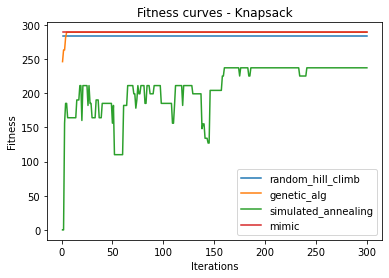

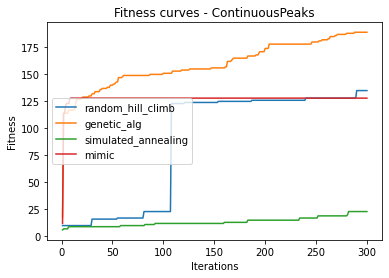

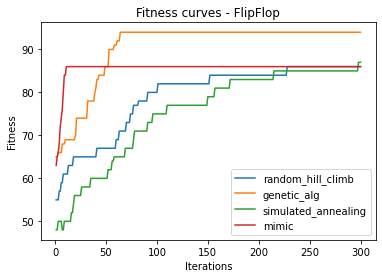

In [15]:
plot_iteration_fitness_curves(curves)

In [16]:
# https://stackoverflow.com/questions/44049999/matplotlib-way-to-annotate-bar-plots-with-lines-and-figures
def plot_bar_graph_speed(times):
    for problem in times:
        plt.figure()
        ax = plt.subplot(111)
        xLabel = []
        y = []
        for algo in times[problem]:
            y.append(round(times[problem][algo], 5))
            xLabel.append(algo)
        x = np.arange(len(xLabel))
        ax.set_xticks(x)
        plt.bar(x, y)
        ax.set_xticklabels(xLabel)
        # Define upper y limit leaving space for the text above the bars.
        up = max(y) * .03
        ax.set_ylim(0, max(y) + 3 * up)
        # Add text to bars
        for xi, yi, l in zip(*[x, y, list(map(str, y))]):
            ax.text(xi - len(l) * .02, yi + up, l,
                    bbox=dict(facecolor='w', edgecolor='w', alpha=.5))
        plt.ylabel("Time in seconds")
        plt.title("Algorithm speed - " + problem)

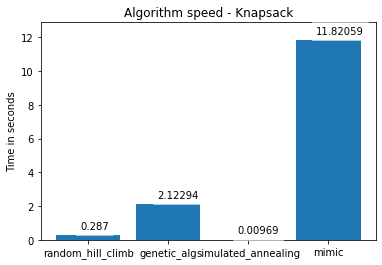

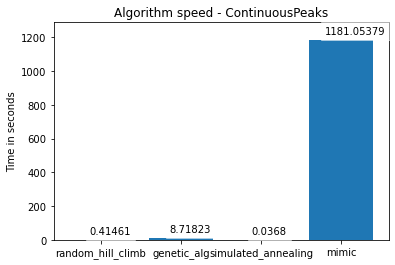

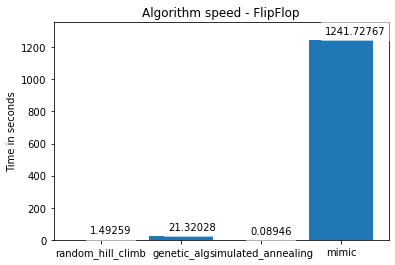

In [17]:
plot_bar_graph_speed(times)

In [18]:
def PrettyPrintParameters(params):
    dfs = []
    for algo in params:
        rowLabels = None
        columnLabels = []
        data = []
        for problem in params[algo]:
            rowLabels = list(params[algo][problem].keys())
            columnLabels.append(problem)
            data.append(list(params[algo][problem].values()))
        df = pd.DataFrame(np.array(data).T, index=rowLabels, columns=columnLabels)
        
        display(df.style.set_caption("Optimal Hyperparameters for " + algo))
        dfs.append(df)
    return dfs

In [19]:
dfs = PrettyPrintParameters(params)

,Knapsack,ContinuousPeaks,FlipFlop
restarts,40,20,20


,Knapsack,ContinuousPeaks,FlipFlop
pop_size,100.000000,300.000000,300.000000
mutation_prob,0.050000,0.100000,0.050000


,Knapsack,ContinuousPeaks,FlipFlop
init_temp,64.000000,0.250000,8.000000
decay,0.990000,0.100000,0.750000
min_temp,0.001000,0.001000,0.001000


,Knapsack,ContinuousPeaks,FlipFlop
pop_size,100.000000,200.000000,200.000000
keep_pct,0.200000,0.200000,0.200000


### Neural Network loss function randomized optimization

In [20]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from copy import deepcopy

def load_prep_data(path_white_wine_quality_csv="winequality-white.csv"):
    wine = pd.read_csv(path_white_wine_quality_csv, delimiter=";")
    df_w = deepcopy(wine)
    # drop wine classes with quality 9 and 3, since they have very 
    # low sample sizes of 5 and 20, respectively
    df_w = df_w[df_w['quality'] != 9][df_w['quality'] != 3]
    
    # save labels
    #save = df_w['quality']
    #standardize
    #df_w = (df_w - df_w.min())/(df_w.max() - df_w.min())
    # replace broken labels with OG labels
    #df_w['quality'] = save
    
    Y_w = deepcopy(df_w)["quality"].to_numpy()
    X_w = deepcopy(df_w).drop("quality", axis=1).to_numpy()
    
    #x_train_w, x_test_w, y_train_w, y_test_w = train_test_split(X_w, Y_w, stratify=Y_w,
    #                                                     random_state=1)

    # Split data into training and test sets
    np.random.seed(1)
    X_train, X_test, y_train, y_test = train_test_split(X_w, Y_w, 
                                                        stratify=Y_w,
                                                        random_state=1,
                                                        test_size=0.2
                                                       )

    # Normalize feature data
    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # One hot encode target values
    one_hot = OneHotEncoder()

    y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
    y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()
    
    
    return X_train_scaled, X_test_scaled, y_train_hot, y_test_hot


def NN_opt_routine(opt_algorithms):
    NN_results = {}
    x_train_w, x_test_w, y_train_w, y_test_w = load_prep_data()
    for algo in opt_algorithms:
        np.random.seed(2)
        print(algo)
        NN_results[algo] = {}
        nn_model = mr.NeuralNetwork(hidden_nodes = [5,2], activation = 'relu', \
                                 algorithm=algo, max_iters = 1500, \
                                 bias = True, is_classifier = True, learning_rate = 0.0001, \
                                 early_stopping = True, clip_max = 5, max_attempts = 100, \
                                 random_state = 3, curve=True)
        startTime = time.time()
        nn_model.fit(x_train_w, y_train_w)
        endTime = time.time()
        timeDiff = endTime - startTime
        print("Training time: " + str(timeDiff))
        
        y_train_pred = nn_model.predict(x_train_w)
        y_test_pred = nn_model.predict(x_test_w)
        
        train_acc = accuracy_score(y_train_w, y_train_pred)
        test_acc = accuracy_score(y_test_w, y_test_pred)
        print("Train acc: " + str(train_acc) + "\nTest acc: " + str(test_acc))
        
        NN_results[algo]['model'] = nn_model
        NN_results[algo]['train_time'] = timeDiff
        NN_results[algo]['train_acc'] = train_acc
        NN_results[algo]['test_acc'] = test_acc
        print()
        
    return NN_results

In [21]:
def loss_curves(NN_results, opt_algorithms):
    for algo in opt_algorithms:
        plt.figure()
        if algo == 'gradient_descent':
            plt.plot(-1*NN_results[algo]['model'].fitness_curve)
        else:
            plt.plot(NN_results[algo]['model'].fitness_curve[:,1], NN_results[algo]['model'].fitness_curve[:,0])
        plt.title(algo + " learning curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

In [22]:
%%time
opt_algorithms = ['gradient_descent', 'random_hill_climb', 'simulated_annealing', 'genetic_alg']
NN_results = NN_opt_routine(opt_algorithms)

gradient_descent
Training time: 20.77252221107483
Train acc: 0.44997434581836837
Test acc: 0.4523076923076923

random_hill_climb
Training time: 12.417678594589233
Train acc: 0.4504874294510005
Test acc: 0.4512820512820513

simulated_annealing
Training time: 18.98573112487793
Train acc: 0.4504874294510005
Test acc: 0.4512820512820513

genetic_alg
Training time: 913.0580036640167
Train acc: 0.4543355566957414
Test acc: 0.4523076923076923

CPU times: user 1h 1min 44s, sys: 2min 33s, total: 1h 4min 18s
Wall time: 16min 5s


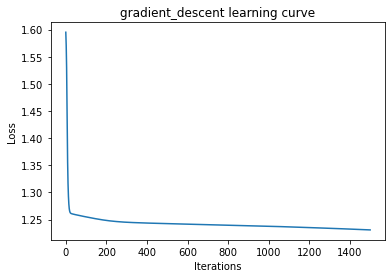

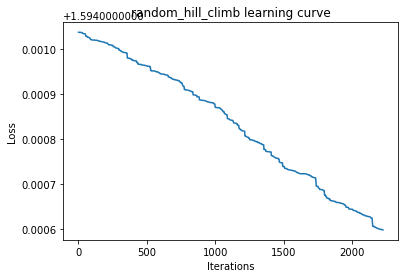

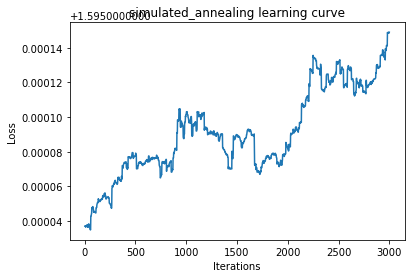

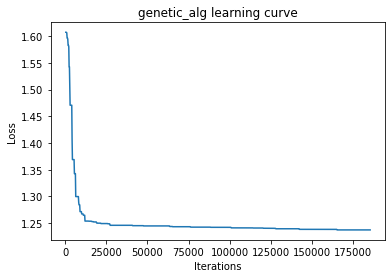

In [23]:
loss_curves(NN_results, opt_algorithms)

In [28]:
pickle_save(NN_results, 'NN_results.pkl')

In [25]:
#NN_results = pickle_load('NN_results.pkl')